# PM2.5 in Baotou against Coal

This notebook plots nasa pm2.5 data from Baotou against coal index. Granger causality and OLS regression with lagged predictors is tested. One can change Baotou to any city/region data obtained from NASA's GIOVANNI tool.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

START_DATE = "2014-01-01"
END_DATE = "2025-07-01"

## Load and Clean Data

In [2]:
def load_pm25_data(csv_path: str, start: str = START_DATE, end: str = END_DATE) -> pd.DataFrame:
    """Load and clean PM2.5 CSV data, trimming to a given date range."""
    df = pd.read_csv(csv_path)
    df = df.iloc[5:].reset_index(drop=True)
    df.columns = ['raw_date', 'pm25_µg_m3']
    df = df[df['raw_date'].str.match(r'\d{4}-\d{2}-\d{2}')].copy()
    df['date'] = pd.to_datetime(df['raw_date'])
    df['pm25_µg_m3'] = df['pm25_µg_m3'].astype(float)
    df = df[(df['date'] >= start) & (df['date'] <= end)]
    return df[['date', 'pm25_µg_m3']]

## Time-Based Averaging Functions

In [3]:
def average_by_period(df: pd.DataFrame, period: str = 'D', datetime_col: str = 'date', value_col: str = 'pm25_µg_m3') -> pd.DataFrame:
    """Compute mean values for a given time period: 'D' (daily), 'W' (weekly), 'M' (monthly)."""
    df = df.copy()
    df['period'] = df[datetime_col].dt.to_period(period).dt.to_timestamp()
    avg_df = (
        df.groupby('period')[value_col]
        .mean()
        .reset_index()
        .rename(columns={value_col: f'{period}_avg_{value_col}'})
    )
    return avg_df

## Plotting

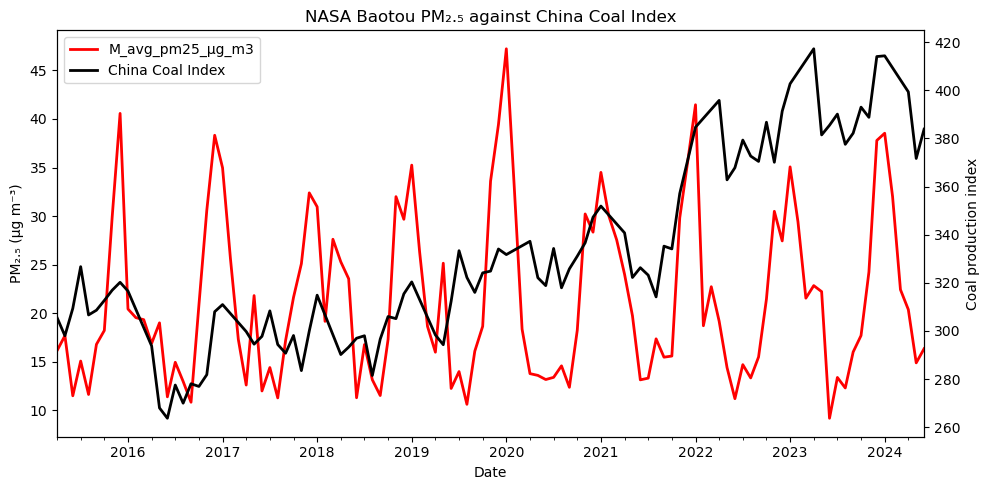

In [5]:
# Baotou PM2.5
city = "Baotou"
city_pm = average_by_period(load_pm25_data(f'umn_bootcamp_capstone_project/data/nasa_data/PM_2_5/surface_density_hourly/{city}.csv'), period='M').set_index('period')

# China-Coal index
coal_df = (
    pd.read_csv('anup_data/ChinaCoal.csv', parse_dates=['Date'])
      .set_index('Date')
      .sort_index()
      .rename(columns={'Coal Production Index': 'CoalIdx'})
      .loc["2014-01-01":"2024-06-01"]
)
# Shift dates up by 1 day
coal_df.index = coal_df.index + pd.Timedelta(days=1)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# PM₂.₅ on left axis (red)
city_pm.plot(ax=ax1, lw=2, color='red', label='PM₂.₅ (Baotou)')
ax1.set_ylabel('PM₂.₅ (µg m⁻³)')
#ax1.set_ylim(-20, 80)

# Coal index on right axis (black)
ax2 = ax1.twinx()
(coal_df['CoalIdx']).plot(ax=ax2, lw=2, color='black', label='China Coal Index')
ax2.set_ylabel('Coal production index')
#ax2.set_ylim(5.5, 6.25)

# Combined legend
lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

ax1.set_title('NASA Baotou PM₂.₅ against China Coal Index')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.show()

## Granger Causality Test
We test whether historical PM2.5 values help predict the coal index using Granger causality analysis.

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests

# Combine PM2.5 and CoalIdx into one dataframe with aligned dates
both = pd.concat([city_pm['M_avg_pm25_µg_m3'], coal_df['CoalIdx']], axis=1).dropna()
both.columns = ['PM25', 'CoalIdx']

# Quick correlation check
corr = both.corr().loc['PM25', 'CoalIdx']
print(f'Correlation between PM2.5 and CoalIdx: {corr:.2f}')

# Run Granger causality test (max lag = 12)
gc_res = grangercausalitytests(both[['CoalIdx', 'PM25']], maxlag=12, verbose=False)

# Extract F-statistics and p-values for each lag
results = [
    {'lag': lag, 'F': res[0]['ssr_ftest'][0], 'p': res[0]['ssr_ftest'][1]}
    for lag, res in gc_res.items()
]
gc_df = pd.DataFrame(results).set_index('lag')
print(gc_df.round(4))

Correlation between PM2.5 and CoalIdx: 0.21
           F       p
lag                 
1     0.4518  0.5032
2     8.2801  0.0005
3    10.4322  0.0000
4     8.2217  0.0000
5     6.2519  0.0001
6     4.9222  0.0003
7     4.1257  0.0007
8     3.5453  0.0017
9     2.3440  0.0234
10    3.5797  0.0009
11    1.6371  0.1119
12    1.6938  0.0930


/home/daniel/Documents/IMA_Bootcamp/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## OLS Regression with Lagged Predictors
We use lagged PM2.5 and CoalIdx values to model current CoalIdx using Ordinary Least Squares (OLS).

In [7]:
import statsmodels.api as sm

# Create lagged variables (up to 3 lags)
df = both.copy()
for lag in range(1, 4):
    df[f'CoalIdx_lag{lag}'] = df['CoalIdx'].shift(lag)
    df[f'PM25_lag{lag}'] = df['PM25'].shift(lag)
df.dropna(inplace=True)

# Define predictors and response
X = df[[f'CoalIdx_lag{i}' for i in range(1, 4)] + [f'PM25_lag{i}' for i in range(1, 4)]]
X = sm.add_constant(X)
y = df['CoalIdx']

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                CoalIdx   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     158.4
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           2.76e-43
Time:                        11:51:50   Log-Likelihood:                -343.82
No. Observations:                  90   AIC:                             701.6
Df Residuals:                      83   BIC:                             719.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.4264     10.994      0.857   